# Init

In [1]:
using LinearAlgebra
using NearestNeighbors
using StaticArrays
include("utils.jl"   )
include("kernels.jl" );

# Problem Domain

In [2]:
_DIM_X    = 2
_DIM_A    = 2
_X_DOMAIN = [-2.0 +2.0; -2.0 +2.0]
_A_DOMAIN = [-0.5 +0.5; -0.5 +0.5]
_Q_DOMAIN = [_X_DOMAIN; _A_DOMAIN]
_LEAFLEN  = 10;

# Simple Test Environment

In [3]:
nX = _DIM_X; # ---- State    dims
nA = _DIM_A; # ---- Action   dims
nQ = nX + nA; # --- Combined dims
X  = zeros( nX ); # Current position
A  = zeros( nA ); # Current effort
Q  = zeros( nQ ); # Current Q state

include("env_simple.jl");

# Fuzzy Q-Learning Procedure

## Agent Components

In [4]:
# Construct grid of anchors
G    = regular_grid_pts_nD( _Q_DOMAIN, [0.5,0.5,0.25,0.25] );
nPts = size( G )[2]; # - Number of anchors
mDim = size( G )[1]; # - Dimensionality of anchors 
pnts = copy( G ); # ---- Interpolation anchors
V    = zeros(Float64, nPts); # Values at anchors
vsts = zeros(Int64, nPts); # - Set number of visits to zero
println( size( G ) )

# Construct spatial trees over anchors (WITHOUT reordering!)
Q_kdTree = KDTree( G            ; leafsize = _LEAFLEN, reorder = false ); # Vals must remain assoc w pnts!
X_kdTree = KDTree( G[1:_DIM_X,:]; leafsize = _LEAFLEN, reorder = false ); # Vals must remain assoc w pnts!
Q_blTree = BallTree( G             ); 
X_blTree = BallTree( G[1:_DIM_X,:] ); 

(4, 2025)


## Agent Params

In [5]:
##### Params #####
gamma = 0.950; # ---------- FIXME
scale = 1.650; # ----------- scale
T     = 6400 #800 #6400; #1600 #3200; # ----------- training period
Y_0   = [0.0 0.0]; # ----- starting state

## Helper Functions

In [6]:
##### Helpers #####

R_func = get_planar_reward_function( _DIM_X, 2 ) # XY function with reward slope 2.0


"""
Random Exploration Policy
"""
function pi_E()
    return sample_bbox_uniform( _A_DOMAIN );
end


"""
Return indices of k Nearest Neighbors of `q` and the degree to which to blend with them
"""
function query_contrib_to_neighbors( kdTree, pnts, vals, q; k = 3 )
    idxs, w_   = K_kNN( kdTree, q; k = k )
    p_  , v_   = fetch_by_indices( pnts, vals, idxs )
    wgts       =  manhatt_contrib_to_q( p_, q )
    return idxs, wgts
end

"""
Perform a linear hyperplane Least Squared Error fit with independent `X` and dependent `Y`
SOURCE: https://stanford.edu/class/engr108/lectures/julia_least_squares_slides.pdf
"""
function least_sqrs_fit( X, Y )
    N          = size( X, 2 )
    beta_tilde = [ ones(N,1) X' ] \ Y;
    fitEQ      = beta_tilde[2:end];
    err        = beta_tilde[1]; 
    return fitEQ, err 
end


"""
Get the vector of steepest ascent on a fit hyperplane at `q` w.r.t. `Y` given column matrix of points `X`
"""
function steepest_Y_ascent( X, Y )
    # mDim     = size( X, 1 ) # -------------- Get problem size
    fitEQ, _ = least_sqrs_fit( X, Y ) # ---- Fit a hyperplane
    return fitEQ
end


"""
Given a spatial tree of states and associate values, find action that ascends the reward gradient at `X`
"""
function optimal_action_for_state( xBlTree, X, radius, pnts, vals, Adomain )
    # 1. Fetch `X` neighborhood anchors within `radius`
    idxs = inrange( xBlTree, X, radius )
    
    # p, v = fetch_by_indices( pnts[_DIM_X+1:end,:], vals, idxs )
    p, v = fetch_by_indices( pnts[1:_DIM_X,:], vals, idxs ) # The model has to be right!
    
    # N. Return optimal action according to local value gradient
    return clamp_vec( 
        steepest_Y_ascent( p, v ), 
        Adomain
    )
end

optimal_action_for_state

## Learning Loop

In [7]:
Rtot = 0.0
    
# 0. Set the initial state
X[:] = Y_0[:]

# 1. For the designated number of training steps, do
for t = 1:T
   
    # Cache last state
    xLast = copy( X )
    aLast = copy( A )
    qLast = get_Q( xLast, aLast )
    
    # 2. Draw action
    a_t  = pi_E()
    a_t  = vec_unit( a_t ) * norm( _A_DOMAIN[:,2] )
    A[:] = a_t
    
    # 3. Generate the next stae
    Q_nxt = dyn( X, A )
    
    # 4. Collect reward R( s, a, s' )
    xP, _ = XA_from_Q( Q_nxt )
    R_t   = R_func( xLast, A, xP )
    Rtot  += R_t
    
    # 5. Get the optimal action at the next state
    a_tp1_opt = optimal_action_for_state( X_blTree, xP, scale, G, V, _A_DOMAIN )
    a_lrg_opt = vec_unit( a_tp1_opt ) * norm( _A_DOMAIN[:,2] )
    a_lim_opt = clamp_vec( a_lrg_opt, _A_DOMAIN )
    if any( isnan, a_lim_opt )
        a_lim_opt = a_t
    end
    
      
    # 6. Compute the value at the next state
    # V_tp1_opt = query_value_w_knn( Q_kdTree, pnts, vals, get_Q( xP, a_lim_opt ); k = 6 )
    V_tp1_opt = query_value_fuzzy( Q_kdTree, G, V, get_Q( xP, a_lim_opt ); k = 3 )
    if isnan( V_tp1_opt )
        V_tp1_opt = 0.0
    end
    
    if t%100 == 0
        # println( xLast, "\t\t", a_t, "\t\t", R_t, "\t\t", a_lim_opt )
        # println( "Value: ", V_tp1_opt )
    end
    
    # 7. Blend the value back into nearest points
    idxs, wgts = query_contrib_to_neighbors( Q_kdTree, G, V, qLast; k = 3 )
    nNear      = size( idxs, 1 )
    
    if t%100 == 0
        # println( xLast, "\t\t", a_t, "\t\t", R_t, "\t\t", a_lim_opt )
        # println( "Value: ", V_tp1_opt )
        println( nNear, " items, ", idxs )
    end
    
    for i = 1:nNear
        j    = idxs[i]
        if !isnan( wgts[i] ) 
            # V[j] =  R_t + gamma * V_tp1_opt 
            # V[j] = wgts[i] * ( R_t + gamma * V_tp1_opt )
            # V[j] = R_t + wgts[i] * ( gamma * V_tp1_opt )
            V[j] = ( 1.0 - wgts[i] )*R_t + wgts[i]*( gamma * V_tp1_opt )
            # V[j] = wgts[i]*R_t + gamma*V_tp1_opt
            # V[j] = (1.0 - wgts[i])*V[j] + wgts[i]*( R_t + gamma * V_tp1_opt )
        end
        # println( [i j], " ", V[j] )
    end
    
    # 12. Set up the next iteration
    X    = copy( xP )
    
    
end

3 items, [1447, 1449, 1448]
3 items, [1872, 1848, 1873]
3 items, [186, 181, 176]
3 items, [648, 624, 649]
3 items, [748, 746, 747]
3 items, [701, 726, 951]
3 items, [299, 300, 295]
3 items, [1174, 1175, 1400]
3 items, [1472, 1466, 1471]
3 items, [771, 747, 772]
3 items, [1290, 1295, 1300]
3 items, [1104, 1110, 1105]
3 items, [960, 954, 955]
3 items, [1482, 1476, 1477]
3 items, [1136, 1126, 1131]
3 items, [880, 854, 879]
3 items, [997, 991, 996]
3 items, [1795, 1570, 1575]
3 items, [1635, 1629, 1630]
3 items, [181, 176, 177]
3 items, [1997, 1991, 1996]
3 items, [2022, 2024, 2023]
3 items, [1660, 1655, 1654]
3 items, [181, 176, 177]
3 items, [36, 31, 26]
3 items, [161, 151, 156]
3 items, [1775, 1770, 1545]
3 items, [755, 979, 980]
3 items, [1576, 1806, 1581]
3 items, [1502, 1501, 1506]
3 items, [204, 178, 179]
3 items, [1453, 1428, 1429]
3 items, [1897, 1896, 1891]
3 items, [251, 227, 226]
3 items, [1800, 1790, 1795]
3 items, [145, 365, 140]
3 items, [702, 704, 703]
3 items, [579, 555, 5

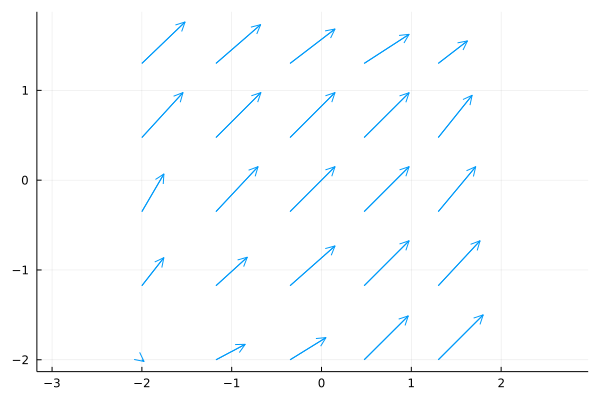

In [8]:
using Plots
using LinearAlgebra

xs = _X_DOMAIN[1,1] : scale/2.0 : _X_DOMAIN[1,2]
ys = _X_DOMAIN[2,1] : scale/2.0 : _X_DOMAIN[2,2]

df(x, y) = optimal_action_for_state( X_blTree, [x; y], scale, G, V, _A_DOMAIN ) 

xxs = [x for x in xs for y in ys]
yys = [y for x in xs for y in ys]

quiver(xxs, yys, quiver=df, aspect_ratio=:equal)

# Optimal Agent Test

In [9]:
Rtot = 0.0

# 0. Set the initial state
X[:] = Y_0[:]

# scale = 1.0

# 1. For the designated number of training steps, do
for t = 1:T
    
    # Cache last state
    xLast = copy( X )
    aLast = copy( A )
    qLast = get_Q( xLast, aLast )
    
    # Choose an action
    A = optimal_action_for_state( X_blTree, X, scale, G, V, _A_DOMAIN )
    A = vec_unit( A ) * norm( _A_DOMAIN[:,2] ) * 0.5
    A = clamp_vec( A, _A_DOMAIN )
    
    # 3. Generate the next stae
    Q_nxt = dyn( X, A )
    
    # 4. Collect reward R( s, a, s' )
    X, _  = XA_from_Q( Q_nxt )
    R_t   = R_func( xLast, A, X )
    Rtot  += R_t
    
    println( "X: ", X, ", A: ", A, ", R: ", R_t )
    
end

println( "Total   Reward: ", Rtot   )
println( "Average Reward: ", Rtot/T )

X: [0.25, 0.25], A: [0.25, 0.25], R: 0.5
X: [0.5, 0.5], A: [0.25, 0.25], R: 1.0
X: [0.7504436725878518, 0.7495555386295982], A: [0.2504436725878519, 0.24955553862959817], R: 1.49999921121745
X: [1.0172476873045522, 0.9815374726913928], A: [0.26680401471670023, 0.23198193406179463], R: 1.998785159995945
X: [1.2855583807081232, 1.2117751147165294], A: [0.2683106934035711, 0.23023764202513652], R: 2.4973334954246527
X: [1.5655549221677119, 1.4276499320775846], A: [0.2799965414595886, 0.2158748173610551], R: 2.9932048542452963
X: [1.824303718373388, 1.6685836583637015], A: [0.25874879620567603, 0.24093372628611695], R: 3.492887376737089
X: [2.0, 1.8447513112925589], A: [0.3065370419077238, 0.17616765292885747], R: 3.844751311292559
X: [2.0, 1.971019732902457], A: [0.33023671162386686, 0.12626842160989812], R: 3.971019732902457
X: [2.0, 2.0], A: [0.33023671162386686, 0.12626842160989812], R: 4.0
X: [2.0, 2.0], A: [0.33023671162386686, 0.12626842160989812], R: 4.0
X: [2.0, 2.0], A: [0.330236